In [1]:
import os
import copy
import torch

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import torchvision.transforms as transforms

from eval import accuracy
from model import MnistCNN
from train import fit, evaluate
from prune import prune_and_finetune
from torchvision.datasets import MNIST
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

In [2]:
BATCH_SIZE = 100
NUM_CLASSES = 10
INPUT_SIZE = 28 * 28
DATASET = MNIST(root='data/', download=True, train=True, transform=transforms.ToTensor())

In [3]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu" 

def split_indices(n, val_pct):
    # Determine size of validation set
    n_val = int(val_pct*n)

    idxs = np.random.permutation(n)

    return idxs[n_val:], idxs[:n_val]

train_indexes, validation_indexes = split_indices(len(DATASET), 0.2)

train_sampler = SubsetRandomSampler(train_indexes)
train_loader = DataLoader(DATASET, BATCH_SIZE, sampler=train_sampler)

val_sampler = SubsetRandomSampler(validation_indexes)
val_loader = DataLoader(DATASET, BATCH_SIZE, sampler=val_sampler)

loss_fun = F.cross_entropy

def predict_image(image, model):
    xb = image.unsqueeze(0).to(dev)
    yb = model(xb)
    yb = yb.to(dev)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

def plot_graph(rng ,acc_list, lost_list, title):
    plt.plot(rng, acc_list, '-b', label='accuracy')
    plt.plot(rng, lost_list, '-r', label='loss')
    plt.legend(loc='upper left')
    plt.xlabel("amount pruned")
    plt.title(title)
    plt.show()


In [4]:
learning_rate = 0.001
if not os.path.isfile('model.pt'):
    model = MnistCNN().to(dev)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    fit(10, model, loss_fun, optimizer, train_loader, val_loader, accuracy)

    torch.save(model.state_dict(), 'model.pt')
else:
    model = MnistCNN()
    model.load_state_dict(torch.load('model.pt'))
    model.to(dev)

In [5]:
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=200)
test_loss, total, test_acc = evaluate(model, loss_fun, test_loader, metric=accuracy)
print(f"Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

Loss: 0.1468, accuracy: 0.9571


In [8]:
def measure_module_sparsity(module, weight=True, bias=False, use_mask=False):

    num_zeros = 0
    num_elements = 0

    if use_mask == True:
        for buffer_name, buffer in module.named_buffers():
            if "weight_mask" in buffer_name and weight == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
            if "bias_mask" in buffer_name and bias == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
    else:
        for param_name, param in module.named_parameters():
            if "weight" in param_name and weight == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()
            if "bias" in param_name and bias == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity

def measure_global_sparsity(model,
                            weight=True,
                            bias=False,
                            conv2d_use_mask=False,
                            linear_use_mask=False):

    num_zeros = 0
    num_elements = 0

    for module_name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=conv2d_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

        elif isinstance(module, torch.nn.Linear):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=linear_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity

In [28]:
prune_model = copy.deepcopy(model)

for module_name, module in prune_model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module,
                                name="weight",
                                amount=0.6)
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module,
                                name="weight",
                                amount=0.4)


test_loader = DataLoader(test_dataset, batch_size=200)
test_loss, total, test_acc = evaluate(prune_model, loss_fun, test_loader, metric=accuracy)
print(f"Amount pruned: 0.3, Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")
num_zeros, num_elements, sparsity = measure_global_sparsity(prune_model, True, False, True, False)
print(f'sparsity: {sparsity}.')

Amount pruned: 0.3, Loss: 0.9417, accuracy: 0.7503
bias Parameter containing:
tensor([-0.0004,  0.0042,  0.0018,  0.0023, -0.0026, -0.0004, -0.0024,  0.0004,
        -0.0015, -0.0015], device='cuda:0', requires_grad=True)
weight_orig Parameter containing:
tensor([[-2.5210, -0.3276, -0.1579,  ..., -0.0947, -1.3552, -1.5173],
        [ 0.9642,  0.8243,  0.3868,  ...,  1.5296, -1.1794, -0.1127],
        [ 0.5476, -0.7999,  0.5761,  ...,  0.5765,  1.1804,  0.4500],
        ...,
        [-0.2226, -0.1105, -0.5490,  ...,  0.9883,  0.8754, -0.8130],
        [ 0.7400, -0.2115, -0.4473,  ...,  0.1295, -1.0134,  1.4894],
        [-0.0424, -0.0496,  0.2579,  ...,  0.2275, -0.3892, -0.9963]],
       device='cuda:0', requires_grad=True)
sparsity: 0.2742382271468144.


Amount pruned: 0.00, Loss: 0.1468, accuracy: 0.9571
weight_orig 0
weight_orig 0
weight_orig 0
sparsity: 0.0.
Amount pruned: 0.10, Loss: 0.1493, accuracy: 0.9554
weight_orig 0
weight_orig 0
weight_orig 0
sparsity: 0.0.
Amount pruned: 0.20, Loss: 0.2562, accuracy: 0.9185
weight_orig 0
weight_orig 0
weight_orig 0
sparsity: 0.0.
Amount pruned: 0.30, Loss: 2.6386, accuracy: 0.1135
weight_orig 0
weight_orig 0
weight_orig 0
sparsity: 0.0.
Amount pruned: 0.40, Loss: 2.6721, accuracy: 0.1135
weight_orig 0
weight_orig 0
weight_orig 0
sparsity: 0.0.
Amount pruned: 0.50, Loss: 2.6203, accuracy: 0.1135
weight_orig 0
weight_orig 0
weight_orig 0
sparsity: 0.0.
Amount pruned: 0.60, Loss: 2.5120, accuracy: 0.1135
weight_orig 0
weight_orig 0
weight_orig 0
sparsity: 0.0.
Amount pruned: 0.70, Loss: 2.3816, accuracy: 0.1028
weight_orig 0
weight_orig 0
weight_orig 0
sparsity: 0.0.
Amount pruned: 0.80, Loss: 2.3364, accuracy: 0.0982
weight_orig 0
weight_orig 0
weight_orig 0
sparsity: 0.0.
Amount pruned: 0.90

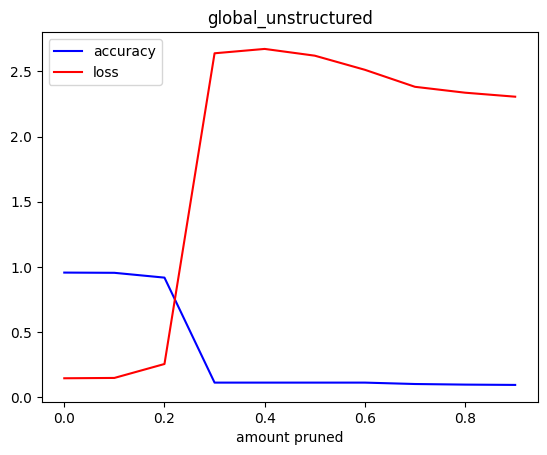

weight_orig 0
weight_orig 0
weight_orig 0
model size: 225.852kB, number of params: 28938, sparsity: 0.0.


In [16]:
prune_model = copy.deepcopy(model)

params_to_prune = [
    (module, "weight") for module in filter(lambda m: type(m) == torch.nn.Conv2d or type(m) == torch.nn.Linear, prune_model.modules())
]

acc = []
lss = []

for num in np.arange(0.0, 1.0, 0.1):
    prune.global_unstructured(
        params_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=num
    )

    test_loader = DataLoader(test_dataset, batch_size=200)
    test_loss, total, test_acc = evaluate(prune_model, loss_fun, test_loader, metric=accuracy)
    print(f"Amount pruned: {num:.2f}, Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")
    acc.append(test_acc)
    lss.append(test_loss)
    num_zeros, num_elements, sparsity = measure_global_sparsity(prune_model)
    print(f'sparsity: {sparsity}.')
plot_graph(np.arange(0.0, 1.0, 0.1), acc, lss, 'global_unstructured')

param_size = 0
for param in prune_model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in prune_model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024
pytorch_total_params = sum(p.numel() for p in prune_model.parameters() if p.requires_grad)
num_zeros, num_elements, sparsity = measure_global_sparsity(prune_model)
print(f'model size: {size_all_mb:.3f}kB, number of params: {pytorch_total_params}, sparsity: {sparsity}.')

Amount pruned: 0.00, Loss: 0.1468, accuracy: 0.9571
Amount pruned: 0.05, Loss: 0.1468, accuracy: 0.9576
Amount pruned: 0.10, Loss: 0.1480, accuracy: 0.9561
Amount pruned: 0.15, Loss: 0.1630, accuracy: 0.9498
Amount pruned: 0.20, Loss: 0.1810, accuracy: 0.9458
Amount pruned: 0.25, Loss: 0.2445, accuracy: 0.9250
Amount pruned: 0.30, Loss: 0.3952, accuracy: 0.8717
Amount pruned: 0.35, Loss: 0.6008, accuracy: 0.8127
Amount pruned: 0.40, Loss: 0.8875, accuracy: 0.7063
Amount pruned: 0.45, Loss: 1.1140, accuracy: 0.6318
Amount pruned: 0.50, Loss: 1.7431, accuracy: 0.4501
Amount pruned: 0.55, Loss: 2.6539, accuracy: 0.1135
Amount pruned: 0.60, Loss: 2.6539, accuracy: 0.1135
Amount pruned: 0.65, Loss: 2.6539, accuracy: 0.1135
Amount pruned: 0.70, Loss: 2.6539, accuracy: 0.1135
Amount pruned: 0.75, Loss: 2.6539, accuracy: 0.1135
Amount pruned: 0.80, Loss: 2.6539, accuracy: 0.1135
Amount pruned: 0.85, Loss: 2.6539, accuracy: 0.1135
Amount pruned: 0.90, Loss: 2.6539, accuracy: 0.1135
Amount prune

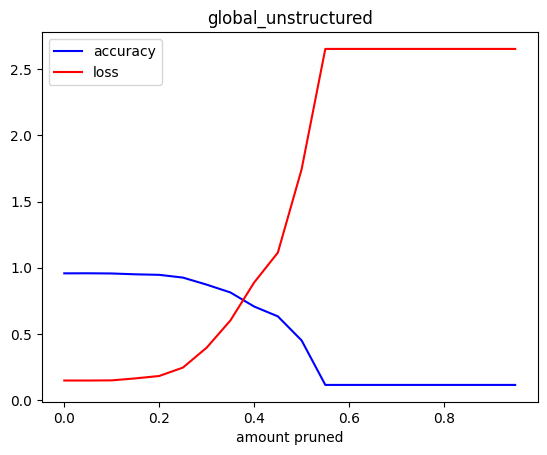

model size: 164.602kB, number of params: 28938, sparsity: 0.0.


In [33]:
prune_model = copy.deepcopy(model)

params_to_prune = [
    (module, "weight") for module in filter(lambda m: type(m) == torch.nn.Conv2d, prune_model.modules())
]

acc = []
lss = []

for num in np.arange(0.0, 1.0, 0.05):
    prune.global_unstructured(
        params_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=num
    )

    test_loader = DataLoader(test_dataset, batch_size=200)
    test_loss, total, test_acc = evaluate(prune_model, loss_fun, test_loader, metric=accuracy)
    print(f"Amount pruned: {num:.2f}, Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")
    acc.append(test_acc)
    lss.append(test_loss)
plot_graph(np.arange(0.0, 1.0, 0.05), acc, lss, 'global_unstructured')

param_size = 0
for param in prune_model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in prune_model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024
pytorch_total_params = sum(p.numel() for p in prune_model.parameters() if p.requires_grad)
num_zeros, num_elements, sparsity = measure_global_sparsity(prune_model)
print(f'model size: {size_all_mb:.3f}kB, number of params: {pytorch_total_params}, sparsity: {sparsity}.')

In [11]:
prune_model = copy.deepcopy(model)
prune_and_finetune(prune_model, train_loader, test_loader, dev, learning_rate, 3, 5)
torch.save(model.state_dict(), 'model_pruned.pt')

Loss: 0.1702, accuracy: 0.9472

Epoch 1, loss: 0.1441, accuracy: 0.9569
Epoch 2, loss: 0.1384, accuracy: 0.9592
Epoch 3, loss: 0.1362, accuracy: 0.9595
Epoch 4, loss: 0.1330, accuracy: 0.9623
Epoch 5, loss: 0.1281, accuracy: 0.9622
Loss: 0.1281, accuracy: 0.9622

Loss: 0.1977, accuracy: 0.9411

Epoch 1, loss: 0.1273, accuracy: 0.9630
Epoch 2, loss: 0.1241, accuracy: 0.9633
Epoch 3, loss: 0.1225, accuracy: 0.9648
Epoch 4, loss: 0.1191, accuracy: 0.9660
Epoch 5, loss: 0.1194, accuracy: 0.9649
Loss: 0.1194, accuracy: 0.9649

Loss: 0.3497, accuracy: 0.8931

Epoch 1, loss: 0.1287, accuracy: 0.9624
Epoch 2, loss: 0.1214, accuracy: 0.9655
Epoch 3, loss: 0.1176, accuracy: 0.9659
Epoch 4, loss: 0.1163, accuracy: 0.9658
Epoch 5, loss: 0.1125, accuracy: 0.9670
Loss: 0.1125, accuracy: 0.9670



In [12]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_zeros, num_elements, sparsity = measure_global_sparsity(model, True, False, False, False)
print(f'model size: {size_all_mb:.3f}kB, number of params: {pytorch_total_params}, sparsity: {sparsity}.')

model size: 113.039kB, number of params: 28938, sparsity: 0.0.


In [13]:
param_size = 0
for param in prune_model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in prune_model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024
pytorch_total_params = sum(p.numel() for p in prune_model.parameters() if p.requires_grad)
num_zeros, num_elements, sparsity = measure_global_sparsity(prune_model, True, False, True, False)
print(f'model size: {size_all_mb:.3f}kB, number of params: {pytorch_total_params}, sparsity: {sparsity}.')

model size: 164.602kB, number of params: 28938, sparsity: 0.3002770083102493.


In [26]:
for module_name, module in prune_model.named_modules():
    for param_name, param in module.named_buffers():
        print(param)
        print(torch.sum(param == 0).item())

tensor([[[[0., 1., 1., 1., 1.],
          [1., 1., 1., 0., 1.],
          [1., 1., 1., 0., 1.],
          [1., 1., 1., 1., 1.],
          [0., 1., 1., 0., 1.]]],


        [[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 0., 1., 1.],
          [1., 1., 0., 1., 1.]]],


        [[[1., 1., 1., 1., 1.],
          [1., 1., 0., 1., 1.],
          [1., 0., 1., 1., 0.],
          [1., 1., 1., 1., 1.],
          [1., 0., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1.],
          [1., 0., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]]],


        [[[1., 0., 1., 1., 1.],
          [1., 1., 1., 1., 0.],
          [1., 1., 1., 0., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1.],
          [1., 1., 1., 1., 1.]]],


        [[[0., 1